In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')


train_path = "/content/drive/MyDrive/CMAPSSData/train_FD001.txt"
test_path  = "/content/drive/MyDrive/CMAPSSData/test_FD001.txt"
RUL_path="/content/drive/MyDrive/CMAPSSData/RUL_FD001.txt"

train_df = pd.read_csv(train_path, sep=" ", header=None)
test_df  = pd.read_csv(test_path, sep=" ", header=None)
RUL_df   = pd.read_csv(RUL_path, sep=" ", header=None)

train_df = train_df.dropna(axis=1, how='all')
test_df  = test_df.dropna(axis=1, how='all')

Mounted at /content/drive


In [4]:
# Rename columns
col_names = ['unit', 'cycle'] + [f'op_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)]
train_df.columns = col_names
test_df.columns  = col_names

# Display basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain units:", train_df['unit'].nunique(), " | Test units:", test_df['unit'].nunique())

print("\nTrain summary:")
print(train_df.describe().T)

# Missing values check
print("\nMissing values in train:\n", train_df.isna().sum().sum())
print("Missing values in test:\n", test_df.isna().sum().sum())

Train shape: (20631, 26)
Test shape: (13096, 26)

Train units: 100  | Test units: 100

Train summary:
             count         mean           std        min        25%  \
unit       20631.0    51.506568  2.922763e+01     1.0000    26.0000   
cycle      20631.0   108.807862  6.888099e+01     1.0000    52.0000   
op_1       20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
op_2       20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
op_3       20631.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   
sensor_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   
sensor_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
sensor_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
sensor_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200   
sensor_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100   
sensor_7   20631.0   553.367711  8.850923e-01 

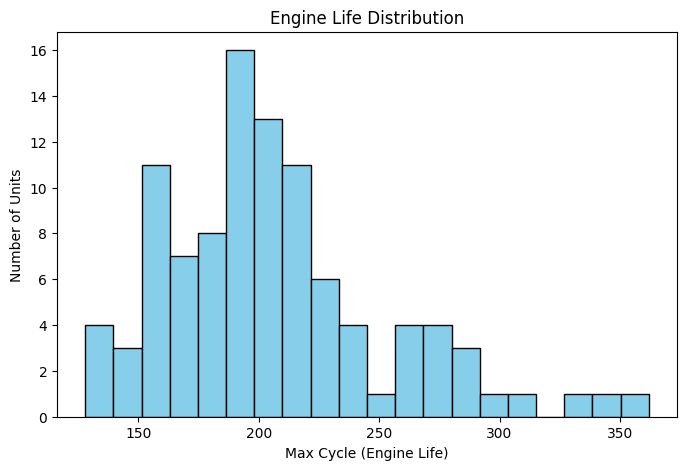

In [ ]:
life = train_df.groupby('unit')['cycle'].max()
plt.figure(figsize=(8,5))
plt.hist(life, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Max Cycle (Engine Life)")
plt.ylabel("Number of Units")
plt.title("Engine Life Distribution")
plt.show()

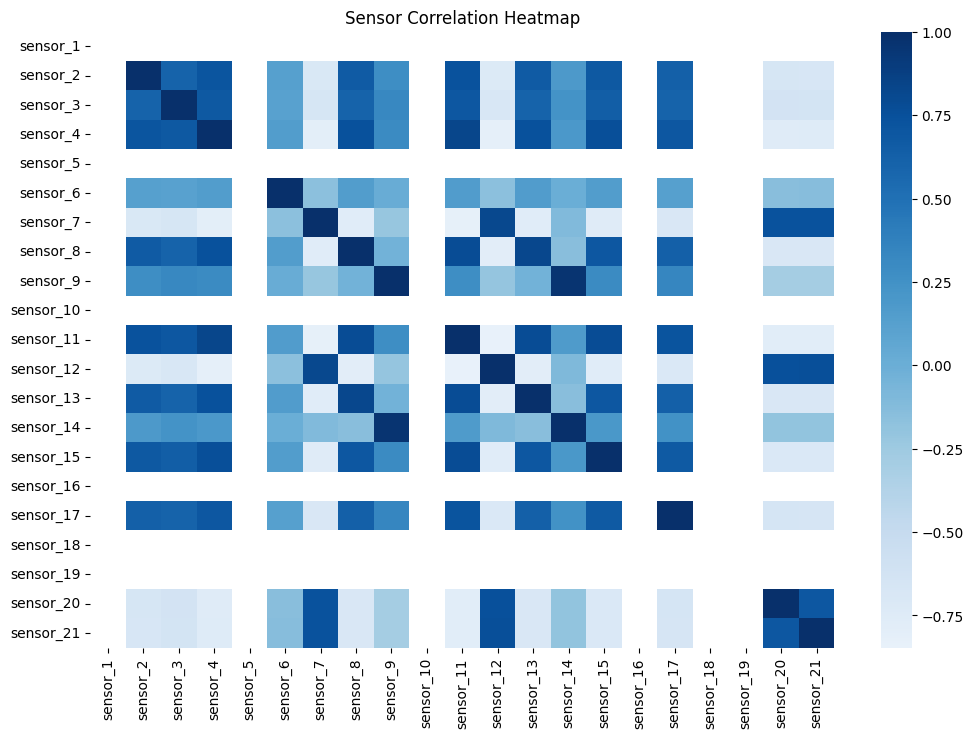

In [6]:
sensor_cols = [c for c in train_df.columns if "sensor" in c]
corr_matrix = train_df[sensor_cols].corr()
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="Blues", center=0)
plt.title("Sensor Correlation Heatmap")
plt.show()





*   Strong positive correlations: sensor_14 & sensor_9
*   Near-zero variance sensors: sensor_1, sensor_5, sensor_10,sensor_16 sensor_18, sensor_19

In [7]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

corr_pairs = upper.stack().reset_index()
corr_pairs.columns = ['Sensor_i', 'Sensor_j', 'Correlation']
corr_pairs = corr_pairs.reindex(corr_pairs['Correlation'].abs().sort_values(ascending=False).index)
print(corr_pairs)

     Sensor_i   Sensor_j  Correlation
72   sensor_9  sensor_14     0.963157
77  sensor_11  sensor_12    -0.846884
31   sensor_4  sensor_11     0.830136
63   sensor_8  sensor_13     0.826084
52   sensor_7  sensor_11    -0.822805
..        ...        ...          ...
85  sensor_12  sensor_14    -0.098141
71   sensor_9  sensor_13    -0.034763
60   sensor_8   sensor_9    -0.032091
41   sensor_6   sensor_9     0.019347
45   sensor_6  sensor_14    -0.002112

[105 rows x 3 columns]


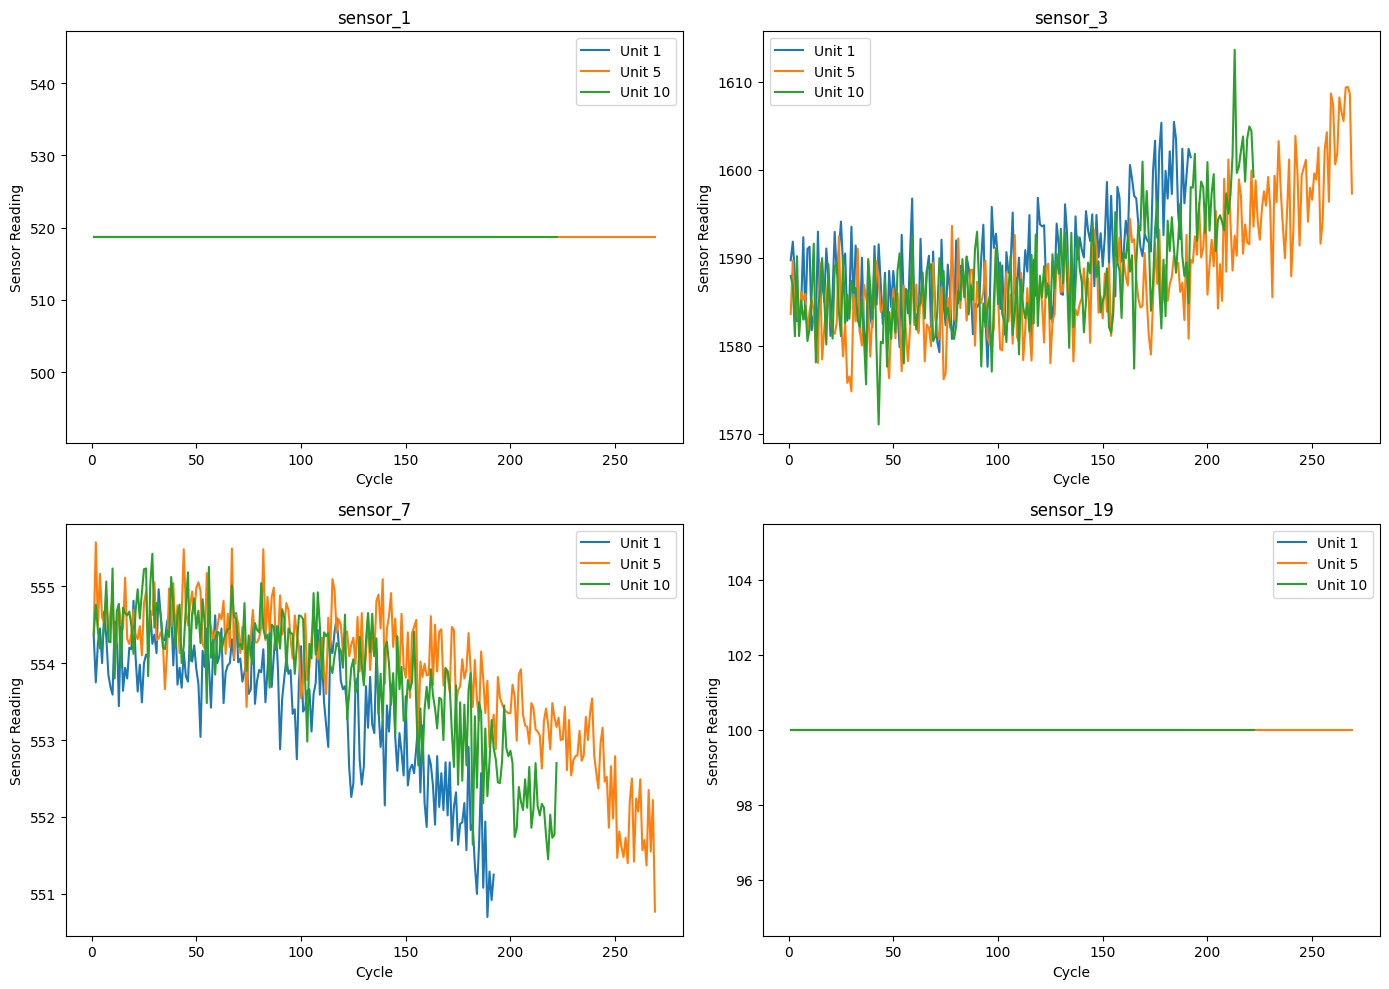

In [8]:
example_sensors = ["sensor_1", "sensor_3", "sensor_7", "sensor_19"]
units_to_plot = [1, 5, 10]

plt.figure(figsize=(14,10))
for i, sensor in enumerate(example_sensors, 1):
    plt.subplot(2,2,i)
    for u in units_to_plot:
        df_u = train_df[train_df["unit"] == u]
        plt.plot(df_u["cycle"], df_u[sensor], label=f"Unit {u}")
    plt.title(sensor)
    plt.xlabel("Cycle")
    plt.ylabel("Sensor Reading")
    plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# max cycle per engine
rul = train_df.groupby("unit")["cycle"].max().reset_index()
rul.columns = ["unit","max_cycle"]

# merge and compute RUL
train_df = train_df.merge(rul, on="unit")
train_df["RUL"] =train_df["max_cycle"] - train_df["cycle"]



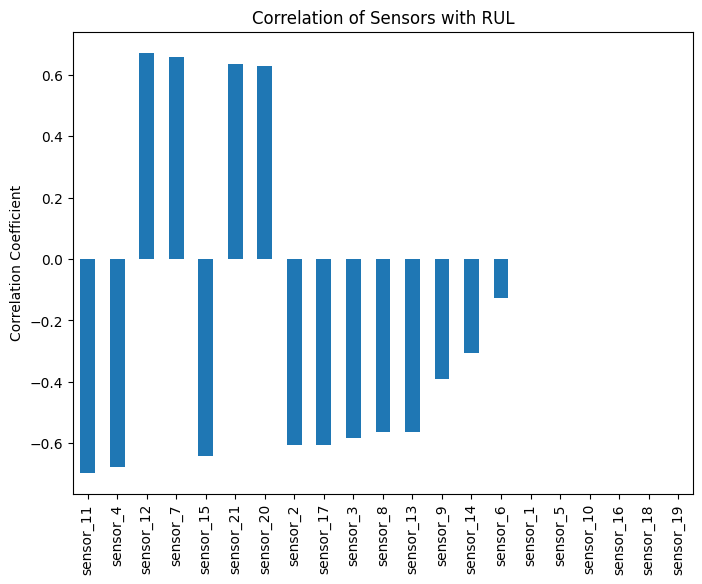

Top correlated sensors with RUL:
 sensor_11    0.696228
sensor_4     0.678948
sensor_12    0.671983
sensor_7     0.657223
sensor_15    0.642667
sensor_21    0.635662
sensor_20    0.629428
sensor_2     0.606484
sensor_17    0.606154
sensor_3     0.584520
Name: RUL, dtype: float64


In [10]:
sensor_cols = [c for c in train_df.columns if 'sensor_' in c]

# Compute correlation between each sensor and RUL
corr = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(key=abs, ascending=False)
plt.figure(figsize=(8,6))
corr.plot(kind='bar')
plt.title('Correlation of Sensors with RUL')
plt.ylabel('Correlation Coefficient')
plt.show()

# Top correlated sensors
top_sensors = corr.abs().nlargest(10)
print("Top correlated sensors with RUL:\n", top_sensors)


In [11]:
# Compute variance per sensor
variances = train_df[sensor_cols].var().sort_values(ascending=False)
low_var = variances[variances < 1e-3]
print("Sensors with very low variance:")
print(low_var.index.tolist())


Sensors with very low variance:
['sensor_6', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_19', 'sensor_18']


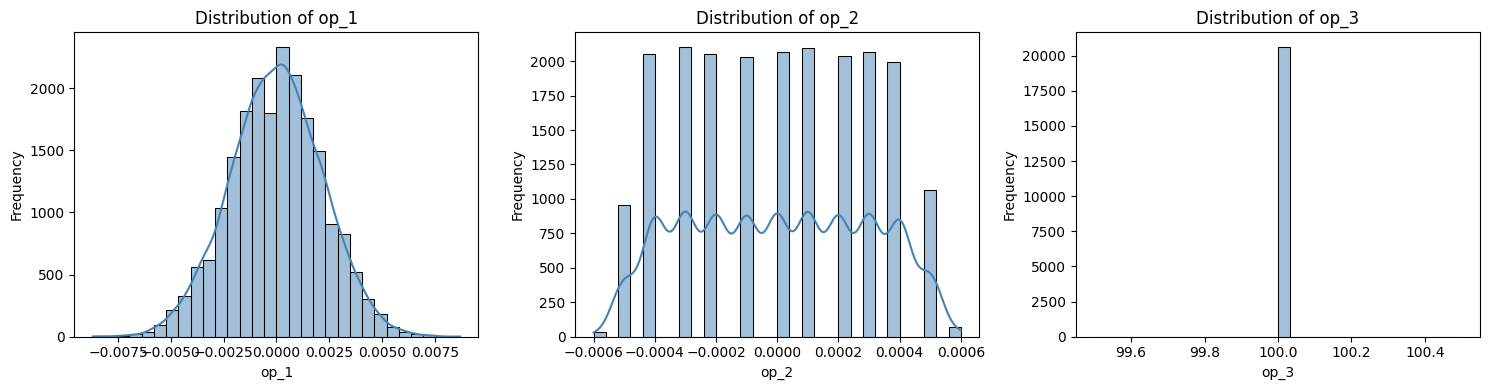


 Operational Settings Summary:

        count        mean       std       min       25%    50%       75%  \
op_1  20631.0   -0.000009  0.002187   -0.0087   -0.0015    0.0    0.0015   
op_2  20631.0    0.000002  0.000293   -0.0006   -0.0002    0.0    0.0003   
op_3  20631.0  100.000000  0.000000  100.0000  100.0000  100.0  100.0000   

           max  unique_values  
op_1    0.0087            158  
op_2    0.0006             13  
op_3  100.0000              1  


In [12]:
op_cols = ['op_1', 'op_2', 'op_3']
plt.figure(figsize=(15, 4))

for i, col in enumerate(op_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(train_df[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()




summary = train_df[op_cols].describe().T
summary['unique_values'] = [train_df[c].nunique() for c in op_cols]
print("\n Operational Settings Summary:\n")
print(summary)


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
col_names = ['unit', 'cycle'] + [f'op_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)]

# Load data
train_df = pd.read_csv(train_path, sep=' ', header=None)
train_df = train_df.dropna(axis=1, how='all')
train_df.columns = col_names

test_df = pd.read_csv(test_path, sep=' ', header=None)
test_df = test_df.dropna(axis=1, how='all')
test_df.columns = col_names

truth_df = pd.read_csv(RUL_path, sep=' ', header=None)
truth_df = truth_df.dropna(axis=1, how='all')
truth_df.columns = ['RUL']

train_df = train_df.loc[:, ~train_df.columns.duplicated()]
rul = train_df.groupby('unit', as_index=False)['cycle'].max().rename(columns={'cycle': 'max_cycle'})
train_df = train_df.merge(rul, on='unit', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

# Test
rul_test = test_df.groupby('unit', as_index=False)['cycle'].max().rename(columns={'cycle':'max_cycle'})
rul_test['RUL_true_end'] = truth_df['RUL']
rul_test['total_life'] = rul_test['max_cycle'] + rul_test['RUL_true_end']
test_df = test_df.merge(rul_test[['unit', 'total_life']], on='unit', how='left')
test_df['RUL'] = test_df['total_life'] - test_df['cycle']

sensor_cols = [c for c in train_df.columns if c.startswith('sensor_')]
variances = train_df[sensor_cols].var().sort_values(ascending=False)
low_var = variances[variances < 1e-3]
print("\n Dropping sensors with very low variance:")
print(low_var.index.tolist())

train_df = train_df.drop(columns=low_var.index)
test_df  = test_df.drop(columns=[c for c in low_var.index if c in test_df.columns])


 Dropping sensors with very low variance:
['sensor_6', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_19', 'sensor_18']


In [25]:
feature_cols = [c for c in train_df.columns if c.startswith('op_') or c.startswith('sensor_')]
unique_units = train_df['unit'].unique()

In [28]:
np.random.seed(42)
train_units = np.random.choice(unique_units, size=int(0.8 * len(unique_units)), replace=False)
test_units  = [u for u in unique_units if u not in train_units]

# Subset the data
X_train = train_df[train_df['unit'].isin(train_units)][feature_cols]
y_train = train_df[train_df['unit'].isin(train_units)]['RUL']

X_test  = train_df[train_df['unit'].isin(test_units)][feature_cols]
y_test  = train_df[train_df['unit'].isin(test_units)]['RUL']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [29]:
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test  = rf_model.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test, y_pred_test)
mae_test  = mean_absolute_error(y_test, y_pred_test)
r2_test   = r2_score(y_test, y_pred_test)

print("\n Random Forest Results:")
print(f"Train -> MSE: {mse_train:.2f}, MAE: {mae_train:.2f}")
print(f"Test  -> MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")



✅ Random Forest (Engine-Level Split) Results:
Train -> MSE: 598.53, MAE: 16.82
Test  -> MSE: 2037.85, MAE: 33.08, R²: 0.605


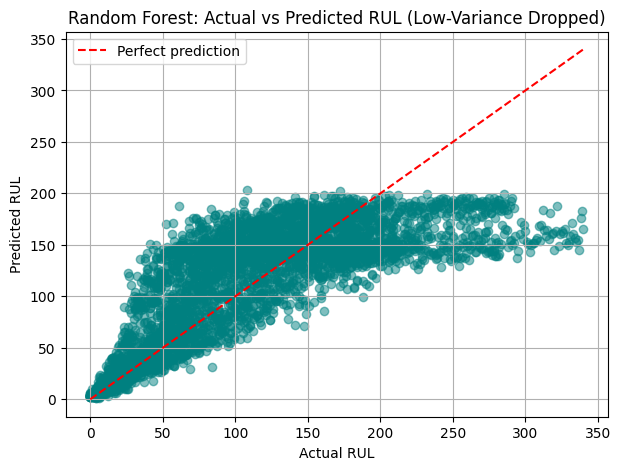

In [30]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest: Actual vs Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()